In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [0]:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

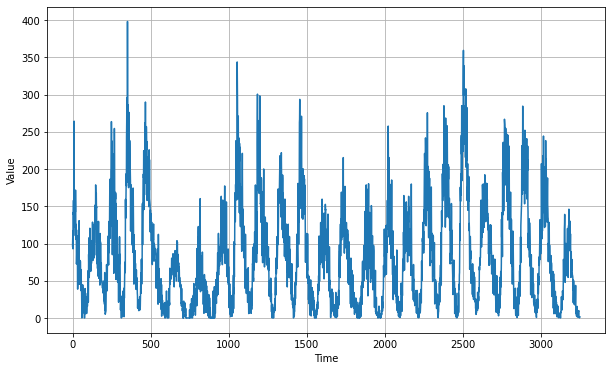

In [6]:

time_step = []
temps = []

with open('/content/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 48ms/step - loss: 75.2498 - mae: 75.7468 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 54ms/step - loss: 73.9731 - mae: 74.4701 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 50ms/step - loss: 71.9216 - mae: 72.4191 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 50ms/step - loss: 69.3977 - mae: 69.8955 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 52ms/step - loss: 66.5253 - mae: 67.0230 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 54ms/step - loss: 63.4441 - mae: 63.9416 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 58ms/step - loss: 60.2531 - mae: 60.7501 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 59ms/step - loss: 57.1044 - mae: 57.6011 - l

(1e-08, 0.0001, 0.0, 60.0)

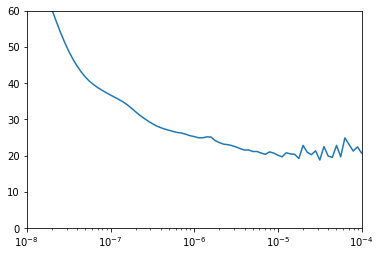

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 1s 32ms/step - loss: 38.6921 - mae: 39.1883
Epoch 2/150
25/25 [==============================] - 1s 33ms/step - loss: 24.9583 - mae: 25.4527
Epoch 3/150
25/25 [==============================] - 1s 31ms/step - loss: 22.2254 - mae: 22.7183
Epoch 4/150
25/25 [==============================] - 1s 32ms/step - loss: 21.0135 - mae: 21.5058
Epoch 5/150
25/25 [==============================] - 1s 31ms/step - loss: 19.6486 - mae: 20.1409
Epoch 6/150
25/25 [==============================] - 1s 33ms/step - loss: 19.2295 - mae: 19.7215
Epoch 7/150
25/25 [==============================] - 1s 32ms/step - loss: 18.7894 - mae: 19.2807
Epoch 8/150
25/25 [==============================] - 1s 31ms/step - loss: 18.2307 - mae: 18.7218
Epoch 9/150
25/25 [==============================] - 1s 33ms/step - loss: 17.9929 - mae: 18.4838
Epoch 10/150
25/25 [==============================] - 1s 32ms/step - loss: 18.0892 - mae: 18.5800
Epoch 11/150
25/25 [=========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

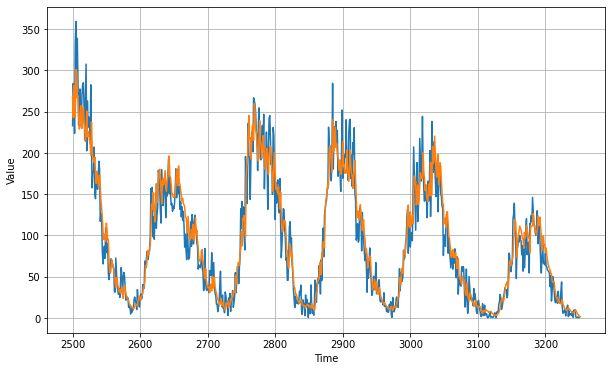

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.93417

In [16]:
print(rnn_forecast)

[268.036     242.72447   282.0624    257.85028   242.99274   301.17096
 298.79422   266.80344   269.40826   244.7681    228.99336   236.00804
 257.41476   231.1921    229.79384   246.93747   256.53983   237.52806
 230.43289   214.0887    225.32811   250.7546    219.40804   225.47646
 225.68346   215.50174   210.93292   197.40799   237.54361   208.53696
 192.73257   194.11722   188.4936    194.9865    174.37398   163.15591
 177.64699   174.2301    160.56654   160.05219   173.0469    158.84857
 142.84578   132.87836   123.690125  106.37963    94.97686    96.28684
 101.80272    92.87266   115.01331   107.48412    94.79516    95.03176
  69.02212    55.574924   54.85971    61.656807   70.618454   66.06333
  62.95204    58.780277   52.113987   43.20915    37.30115    48.5412
  49.121468   39.451935   35.767902   32.01469    33.909718   29.879526
  35.10274    37.590553   29.561207   23.70551    33.475105   39.057987
  34.985115   29.621595   26.015884   23.19289    22.560669   20.965261
  17